<a href="https://colab.research.google.com/github/yuhei1027/myrepository/blob/main/%E6%99%82%E7%B3%BB%E5%88%97_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import lightgbm as lgb
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression,LinearRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
df=pd.read_csv('./drive/MyDrive/MyDatasets/airplane/AirPassengers.csv')
df.columns = ['ds', 'y']
df.head()

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


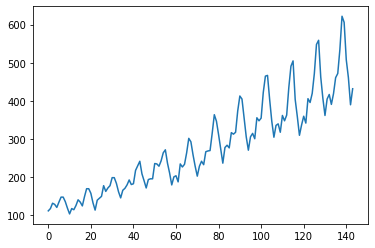

In [ ]:
df['y'].plot()

In [ ]:
df['y_lag1']=df['y'].shift(1)
df['y_lag12']=df['y'].shift(12)
df['y_roll12']=df['y'].rolling(12).mean()
df['y_diff']=df['y'].diff()
df=df.dropna().reset_index(drop=True)
train_cols=['y_lag12']

X_train,X_valid,y_train,y_valid=train_test_split(df[train_cols],df['y'],test_size=0.1,shuffle=False)

In [ ]:
params = {
    #fixed
    'min_child_samples':3,
    'num_iterations':200
}
model = lgb.LGBMRegressor(**params)

model.fit(X_train, y_train)
pred=model.predict(X_valid)
score=mape(pred,y_valid)
print(score)

0.06063920292128945


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


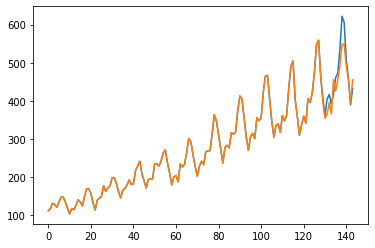

In [ ]:
y_new=np.concatenate([y_train,pred])
plt.plot(df['y'])
plt.plot(y_new)

In [ ]:
y_train.shape,y_valid.shape

((129,), (15,))

# 回帰

In [ ]:
df=pd.read_csv('./drive/MyDrive/MyDatasets/airplane/AirPassengers.csv')
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df = pd.read_csv("https://raw.githubusercontent.com/statsmodels/statsmodels/main/statsmodels/datasets/nile/nile.csv", index_col="year")
df=df.reset_index()
df.columns = ['ds', 'y']
print(df.shape)
df.head()

(100, 2)


,ds,y
0,1871,1120
1,1872,1160
2,1873,963
3,1874,1210
4,1875,1160


In [ ]:
def make_features(df):
  train_cols=[]
  for lag in [1,2,3,4,5]:
    df[f'y_lag_{lag}']=df['y'].shift(lag)
    df[f'y_roll_mean_{lag}']=df['y'].rolling(lag).mean().shift(1)
    df[f'y_roll_max_{lag}']=df['y'].rolling(lag).max().shift(1)
    df[f'y_roll_min_{lag}']=df['y'].rolling(lag).min().shift(1)
    #df[f'y_roll_std_{lag}']=df['y'].rolling(lag).std().shift(1)
    df[f'y_roll_max-min_{lag}']=df[f'y_roll_max_{lag}']-df[f'y_roll_min_{lag}']


    train_cols.append(f'y_lag_{lag}')
    train_cols.append(f'y_roll_mean_{lag}')
    train_cols.append(f'y_roll_max_{lag}')
    train_cols.append(f'y_roll_min_{lag}')
    #train_cols.append(f'y_roll_std_{lag}')
    train_cols.append(f'y_roll_max-min_{lag}')
  
  #ss =StandardScaler()
  #df[train_cols]=ss.fit_transform(df[train_cols])
 

  return df,train_cols

def recursive_predict(train_df,valid_df,model,train_cols):
  n_train=len(train_df)
  n_valid=len(valid_df)
  X=pd.concat([train_df,valid_df],ignore_index=True)
  preds=[]

  for i in range(n_train,n_train+n_valid):
    X,_=make_features(X)
    X_valid=X[train_cols].iloc[i:i+1]

    pred=model.predict(X_valid)
    preds.append(pred[0])
  
  return preds



In [ ]:
valid_length=25
train_df,valid_df=df.iloc[:-valid_length].reset_index(drop=True),df.iloc[-valid_length:].reset_index(drop=True)
train_df,train_cols=make_features(train_df)
train_df=train_df.dropna()

#train_cols=['y_lag1','y_lag12','y_roll12']
X_train,y_train=train_df[train_cols],train_df['y']

train_df.head()

,ds,y,y_lag_1,y_roll_mean_1,y_roll_max_1,y_roll_min_1,y_roll_max-min_1,y_lag_2,y_roll_mean_2,y_roll_max_2,...,y_lag_4,y_roll_mean_4,y_roll_max_4,y_roll_min_4,y_roll_max-min_4,y_lag_5,y_roll_mean_5,y_roll_max_5,y_roll_min_5,y_roll_max-min_5
5,1876,1160,1160.0,1160.0,1160.0,1160.0,0.0,1210.0,1185.0,1210.0,...,1160.0,1123.25,1210.0,963.0,247.0,1120.0,1122.6,1210.0,963.0,247.0
6,1877,813,1160.0,1160.0,1160.0,1160.0,0.0,1160.0,1160.0,1160.0,...,963.0,1123.25,1210.0,963.0,247.0,1160.0,1130.6,1210.0,963.0,247.0
7,1878,1230,813.0,813.0,813.0,813.0,0.0,1160.0,986.5,1160.0,...,1210.0,1085.75,1210.0,813.0,397.0,963.0,1061.2,1210.0,813.0,397.0
8,1879,1370,1230.0,1230.0,1230.0,1230.0,0.0,813.0,1021.5,1230.0,...,1160.0,1090.75,1230.0,813.0,417.0,1210.0,1114.6,1230.0,813.0,417.0
9,1880,1140,1370.0,1370.0,1370.0,1370.0,0.0,1230.0,1300.0,1370.0,...,1160.0,1143.25,1370.0,813.0,557.0,1160.0,1146.6,1370.0,813.0,557.0


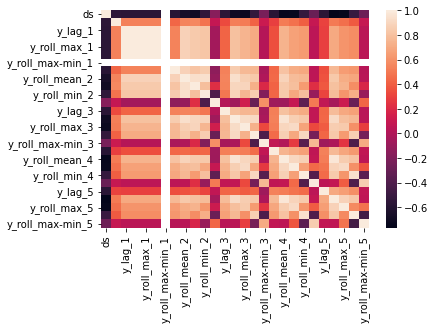

In [ ]:
import seaborn as sns
data=train_df.corr()
sns.heatmap(data)

In [ ]:
model=ARDRegression()
#model=LinearRegression()
params = {
    #fixed
    'min_child_samples':3,
    'num_iterations':200
}
#model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)
pred=recursive_predict(train_df.iloc[-50:],valid_df,model,train_cols)
score=mape(pred,valid_df['y'])
print(score)

0.11578942663949697


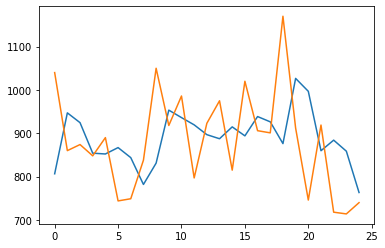

In [ ]:
plt.plot(pred)
plt.plot(valid_df['y'])

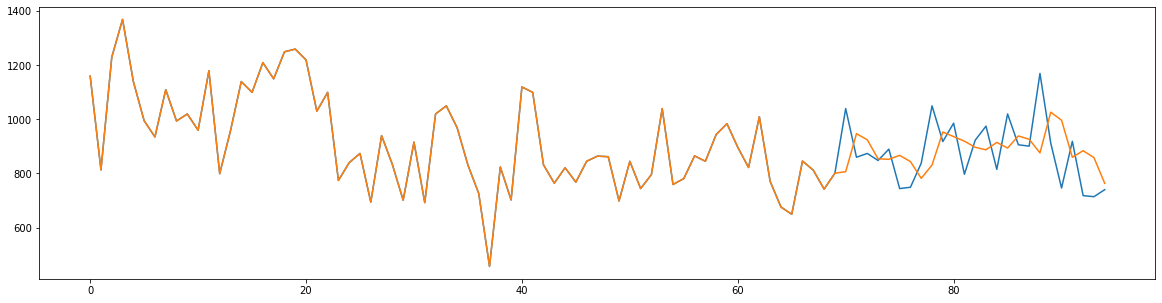

In [ ]:
plt.figure(figsize=(20,5))
y_new=np.concatenate([y_train,pred])
y_original=pd.concat([train_df['y'],valid_df['y']],ignore_index=True)
plt.plot(y_original)
plt.plot(y_new)